In [1]:
import numpy as np
from copy import copy
import pandas as pd
import time

import matplotlib.pyplot as plt

df = pd.DataFrame(columns=['Problem', 'Method', 'f(x)', 'Iterations', 'Time', 'Termination'])

In [2]:
c1 = 10e-4
c2 = 0.9
max_iter = 1000
epsilon_min = 10e-8
tol = 10e-8
eta = 0.01

verbose = True

params = [tol, max_iter, epsilon_min, eta, c1, c2, verbose]

In [3]:
def print_results(iter, f, x, grad_f, alpha):
    if iter == 0:
        print(f'{"iter":<5} {"f(x)":<15} {"||grad_f(x)||":<30} {"alpha":<15}')
    
    print(f'{iter:<5} {f(x):<15.10f} {np.linalg.norm(grad_f(x)):<30.10f} {alpha:<15.10f}')



In [4]:
# Wolfe line search
def wolfe_line_search(phi, phi_prime, x_k, p_k, c1=10e-4, c2=0.9, max_iter=100):
    """
    Wolfe line search algorithm.

    Parameters:
    phi: function, the objective function.
    phi_prime: function, the derivative of the objective function.
    x_k: array-like, current point.
    p_k: array-like, search direction.
    c1: float, constant for the Armijo condition (0 < c1 < c2 < 1).
    c2: float, constant for the curvature condition (0 < c1 < c2 < 1).
    max_iter: int, maximum number of iterations.

    Returns:
    alpha: float, step size.
    """
    alpha_l = 0
    alpha_u = float('inf')
    alpha = 1.0

    for _ in range(max_iter):
        phi_alpha = phi(x_k + alpha * p_k)
        phi_0 = phi(x_k)
        phi_prime_0 = phi_prime(x_k).dot(p_k)

        # Armijo condition
        if phi_alpha > phi_0 + c1 * alpha * phi_prime_0:
            alpha_u = alpha
        else:
            phi_prime_alpha = phi_prime(x_k + alpha * p_k).dot(p_k)
            # Curvature condition
            if phi_prime_alpha < c2 * phi_prime_0:
                alpha_l = alpha
            else:
                return alpha

        if alpha_u < float('inf'):
            alpha = (alpha_l + alpha_u) / 2
        else:
            alpha = 2 * alpha

    return alpha


In [5]:
# Newton-CG method
def newton_cg(f, grad_f, hess_f, x0, params):

    time_start = time.time()

    tol, max_iter, epsilon_min, eta, c1, c2, verbose = params

    x = x0.copy()
    grad_x0 = grad_f(x0)
    
    grad_norm_hist = []

    for iter in range(max_iter):
        grad = grad_f(x)
        grad_norm_hist.append(np.linalg.norm(grad))

        if np.linalg.norm(grad) < tol * max(np.linalg.norm(grad_x0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad))
            return f(x), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist

        H = hess_f(x)
        
        # Conjugate Gradient to solve Newton direction
        z = np.zeros_like(grad)
        r = grad.copy()
        d = -r.copy()
        
        for j in range(len(x)):
            Hd = H @ d
            dHd = d @ Hd 
            if dHd <= 0:
                p_k = -grad if j == 0 else z
                break
            alpha_j = (r @ r) / (dHd)
            z_new = z + alpha_j * d
            r_new = r + alpha_j * Hd
            
            if np.linalg.norm(r_new) <= eta * np.linalg.norm(grad):
                p_k = z_new
                break
            
            beta_j = (r_new @ r_new) / (r @ r)
            d = -r_new + beta_j * d
            z, r = z_new, r_new
        else:
            p_k = z
        
        # Perform line search
        alpha_k = wolfe_line_search(f, grad_f, x, p_k, c1, c2)
        x = x + alpha_k * p_k

        if verbose:
            print_results(iter, f, x, grad_f, alpha_k)

    print("f(x*) =", f(x))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x)))
    print("Number of iterations:", iter)
    return f(x), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist


def bfgs(f, grad_f, H0, x0, params):
    """
    BFGS algorithm for unconstrained optimization.

    Parameters:
    f: function, the objective function.
    grad_f: function, the gradient of the objective function.
    x0: array-like, initial point.
    H0: array-like, initial inverse Hessian approximation.
    epsilon_min: float, small positive constant for curvature condition.
    max_iter: int, maximum number of iterations.
    tol: float, convergence tolerance.

    Returns:
    x_k: array-like, approximate solution.
    """
    time_start = time.time()

    tol, max_iter, epsilon_min, eta, c1, c2, verbose = params

    x_k = x0.copy()
    H_k = H0.copy()

    grad_x0 = grad_f(x0)
    grad_norm_hist = []
    
    for iter in range(max_iter):
        grad_k = grad_f(x_k)
        grad_norm_hist.append(np.linalg.norm(grad_k))

        if np.linalg.norm(grad_k) < tol * max(np.linalg.norm(grad_x0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad_k))
            return f(x_k), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist

        # Step 1: Compute search direction
        p_k = -H_k.dot(grad_k)

        # Step 2: Choose steplength using Armijo backtracking line search
        alpha_k = wolfe_line_search(f, grad_f, x_k, p_k, c1, c2)

        # Step 3: Update the iterate
        x_k_plus_1 = x_k + alpha_k * p_k

        # Step 4: Define s_k and y_k
        s_k = x_k_plus_1 - x_k
        y_k = grad_f(x_k_plus_1) - grad_k

        # Step 5: Check curvature condition
        if y_k.dot(s_k) > epsilon_min * np.linalg.norm(y_k) * np.linalg.norm(s_k):
            # Step 6: Compute H_{k+1} by the BFGS update
            rho_k = 1.0 / y_k.dot(s_k)
            I = np.eye(len(x0))
            H_k = (I - rho_k * np.outer(s_k, y_k)).dot(H_k).dot(I - rho_k * np.outer(y_k, s_k)) + rho_k * np.outer(s_k, s_k)

        # Step 8: Update k
        x_k = x_k_plus_1

        if verbose:
            print_results(iter, f, x_k, grad_f, alpha_k)

    print("f(x*) =", f(x_k))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x_k)))
    print("Number of iterations:", iter)
    return f(x_k), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist



In [6]:
def two_loop_recursion(grad, s_list, y_list, rho_list, gamma_k):
    """
    Performs the L-BFGS two-loop recursion to compute the search direction.

    Parameters:
        grad: Gradient at the current iterate.
        s_list: List of stored s vectors (x_{k+1} - x_k).
        y_list: List of stored y vectors (grad_{k+1} - grad_k).
        rho_list: List of stored rho values (1 / y.T @ s).
        gamma_k: Scaling factor for initial Hessian approximation.

    Returns:
        p: Search direction.
    """
    q = grad.copy()
    alpha_list = []

    # First loop (going backward)
    for i in range(len(s_list) - 1, -1, -1):
        alpha = rho_list[i] * np.dot(s_list[i], q)
        q -= alpha * y_list[i]
        alpha_list.append(alpha)

    # Apply initial Hessian approximation H0 = gamma_k * I
    r = gamma_k * q

    # Second loop (going forward)
    for i in range(len(s_list)):
        beta = rho_list[i] * np.dot(y_list[i], r)
        r += s_list[i] * (alpha_list[i] - beta)

    return -r  # Negative for descent direction

def compute_gamma(s, y):
    """
    Computes the scaling factor γ_k = (s.T y) / (y.T y).
    If s and y are not available (first iteration), γ_k = 1.

    Parameters:
        s: Previous step s_k-1 = x_k - x_k-1.
        y: Previous gradient difference y_k-1 = grad_k - grad_k-1.

    Returns:
        gamma_k: Scaling factor.
    """
    return np.dot(s, y) / np.dot(y, y) if np.dot(y, y) > 1e-15 else 1.0

def lbfgs(f, grad_f, x0, params):
    """
    Implements the L-BFGS optimization algorithm.

    Parameters:
        f: Function to minimize.
        grad_f: Gradient of the function.
        x0: Initial point.
        tol: Stopping criterion for gradient norm.
        max_iter: Maximum number of iterations.
        epsilon_min: Threshold for skipping updates.

    Returns:
        x: Optimized solution.
        fval: Function value at the solution.
        k: Number of iterations performed.
    """
    time_start = time.time()
    tol, max_iter, epsilon_min, eta, c1, c2, verbose = params

    x = x0.copy()
    n = len(x)
    grad_x0 = grad_f(x0)
    grad_norm_hist = []

    m = min(n, 10)  # Memory size
    s_list, y_list, rho_list = [], [], []

    gamma_k = 1.0  # Initial Hessian scaling

    for iter in range(max_iter):
        grad = grad_f(x)
        grad_norm_hist.append(np.linalg.norm(grad))

        if np.linalg.norm(grad) < tol * max(np.linalg.norm(grad_x0), 1):
            print("Converged. Gradient norm is less than tolerance.")
            print("gradient norm:", np.linalg.norm(grad))
            return f(x), iter+1, time.time()-time_start, "Converged. Gradient norm is less than tolerance.", grad_norm_hist


        # Compute search direction using two-loop recursion
        p = two_loop_recursion(grad, s_list, y_list, rho_list, gamma_k)

        # Perform line search
        alpha = wolfe_line_search(f, grad_f, x, p, c1, c2)

        # Update iterate
        x_new = x + alpha * p
        s_k = x_new - x
        y_k = grad_f(x_new) - grad_f(x)

        # Check curvature condition: y_k.T s_k > ε_min * ||y_k|| * ||s_k||
        if np.dot(y_k, s_k) > epsilon_min * np.linalg.norm(y_k) * np.linalg.norm(s_k):
            if len(s_list) >= m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)

                rho_list.append(1.0 / np.dot(y_k, s_k))
                s_list.append(s_k)
                y_list.append(y_k)

        # Update γ_k using the latest s_k and y_k
        gamma_k = compute_gamma(s_k, y_k)

        x = x_new.copy()

        if verbose:
            print_results(iter, f, x, grad_f, alpha)

    print("f(x*) =", f(x))
    print("||grad_f(x*)|| =", np.linalg.norm(grad_f(x)))
    print("Number of iterations:", iter)
    return f(x), iter+1, time.time()-time_start, "Didn't Converge. Maximum number of iterations reached.", grad_norm_hist


In [7]:
# Rosenbrock function
def f_rosenbrock(x):
    coupled_term = 100*(x[1:]**2-x[:-1])**2
    diagonal_term = (x  - 1.)**2
    return np.sum(coupled_term) + np.sum(diagonal_term)

def grad_f_rosenbrock(x):
    grad = 2.0 * (x - 1.0)
    diffs = x[1:]**2 - x[:-1]
    grad[:-1] += -200.0 * diffs
    grad[1:]  += 400.0 * x[1:] * diffs
    return grad

def hessian_f_rosenbrock(x):
    d = len(x)
    diag_main = np.full(d, 2.0)
    diag_main[:-1] += 200.0
    diag_main[1:] += 1200.0 * x[1:]**2 - 400.0 * x[:-1]
    off_diag = np.zeros(d - 1)
    off_diag = -400.0 * x[1:]
    H = (
        np.diag(diag_main) +
        np.diag(off_diag, k=1) +
        np.diag(off_diag, k=-1)
    )
    return H


iter  f(x)            ||grad_f(x)||                  alpha          
0     76.7461738586   301.5541472236                 0.0019531250   
1     12.7896998602   88.2908956001                  0.0039062500   
2     2.9156438691    5.9674054551                   1.0000000000   
3     2.8604879707    1.4143747089                   1.0000000000   
4     2.8202403684    2.4530300878                   16.0000000000  
5     2.7860880768    12.0528531230                  0.5000000000   
6     2.6945744193    3.2925853482                   1.0000000000   
7     2.6345141020    3.6117105383                   1.0000000000   
8     2.5992779453    11.6172208939                  0.5000000000   
9     2.4771400337    2.8333140693                   1.0000000000   
10    2.3215992397    4.2704143780                   2.0000000000   
11    2.2491817151    6.9580097717                   0.2500000000   
12    2.1158083069    6.7147011948                   1.0000000000   
13    1.7271546775    3.0732710131

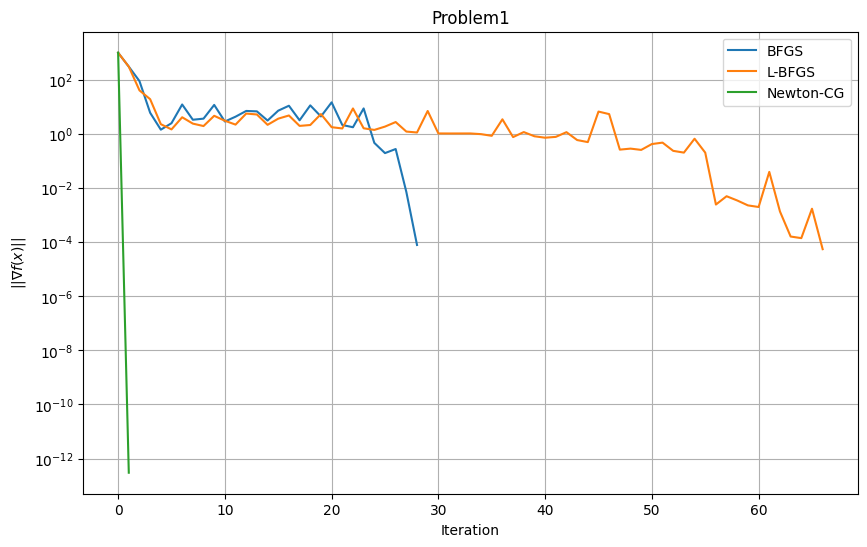

In [8]:
# Problem1: Extended Rosenbrock function with n = 2, x0 = [-1.2, 1]
Problem= 'Problem1'
n = 2
x0 = np.array([-1.2, 1.0])

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     681.2185440212  1269.1196418085                0.0019531250   
1     506.2242340004  1035.1631277440                0.0009765625   
2     416.1412956928  874.9767056434                 0.0009765625   
3     376.0877965695  826.3120515196                 0.0009765625   
4     316.1511843728  777.2627429383                 0.0019531250   
5     221.7623349199  874.2272080067                 0.0039062500   
6     133.7368949557  459.2447925662                 0.0009765625   
7     127.5108653570  497.0203904541                 0.0009765625   
8     127.3463739191  498.2288342120                 0.0019531250   
9     126.5816900079  508.3480848323                 0.0156250000   
10    106.8095265743  583.6153252475                 0.1250000000   
11    27.2107957526   272.4965547960                 1.0000000000   
12    9.3445155003    92.4692706568                  1.0000000000   
13    5.2628453271    62.237982308

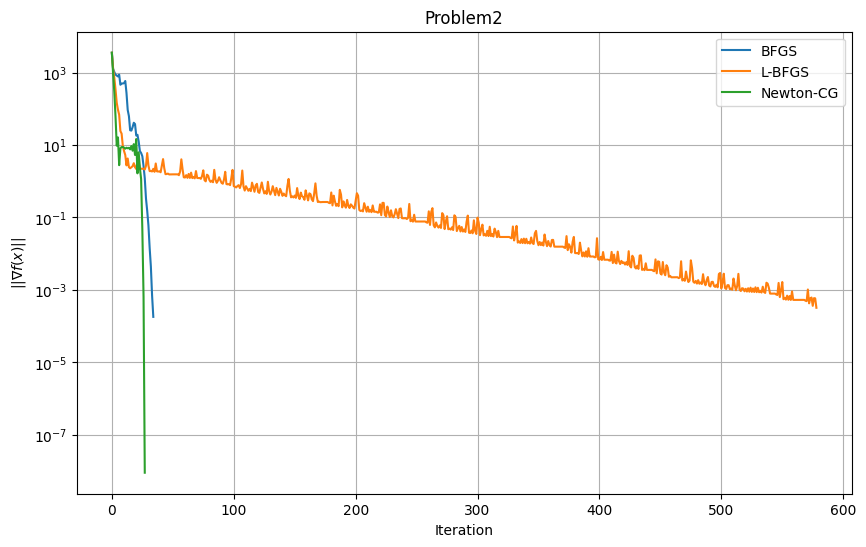

In [9]:
# Problem2: Extended Rosenbrock function with n = 10, x0 = (-1, ..., -1)
Problem= 'Problem2'
n = 10
x0 = -1 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     1144.6832033107 1101.7463855358                0.0019531250   
1     674.6443769247  921.4261792241                 0.0019531250   
2     655.3286084401  990.0950132091                 0.0009765625   
3     652.1465012881  962.6098730217                 0.0039062500   
4     642.8610037794  958.1105863588                 0.0039062500   
5     631.6823038998  954.2218393208                 0.0039062500   
6     601.0837705260  958.8059717768                 0.0156250000   
7     527.5189220833  888.0455049820                 0.0156250000   
8     223.8200173559  351.0326519211                 0.0078125000   
9     190.4757926146  243.8272119367                 0.0156250000   
10    183.1868416231  253.7506945244                 0.0625000000   
11    171.3012729877  333.0432704614                 0.0625000000   
12    42.6681537164   98.0691732477                  1.0000000000   
13    28.2101211456   82.512544650

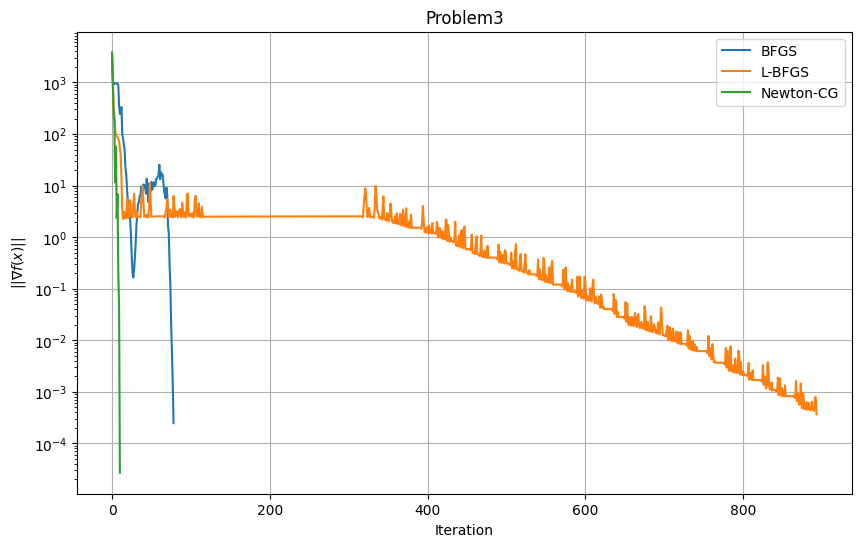

In [10]:
# Problem3: Extended Rosenbrock function with n = 10, x0 = (2, ..., 2)
Problem= 'Problem3'
n = 10
x0 = 2 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     2724.3242394179 1997.2001690628                0.0019531250   
1     2539.9372694231 1811.7063362423                0.0009765625   
2     2462.1934095534 1739.1293080212                0.0009765625   
3     2460.9735891758 1775.4916136564                0.0019531250   
4     2459.7434191392 1820.5123934552                0.0039062500   
5     2133.2134532239 1865.0336980344                0.0039062500   
6     1996.7245257869 1907.6424519660                0.0002441406   
7     1979.0898275112 2003.0682190808                0.0009765625   
8     1975.7856621319 1947.2873771166                0.0009765625   
9     1893.2598758973 1761.6924823543                0.0156250000   
10    1605.7227910504 1482.5015527094                0.0039062500   
11    1556.2746525621 1654.4689399286                0.0019531250   
12    1268.8982128783 1478.0741813790                0.0019531250   
13    832.9987792764  1295.7615363

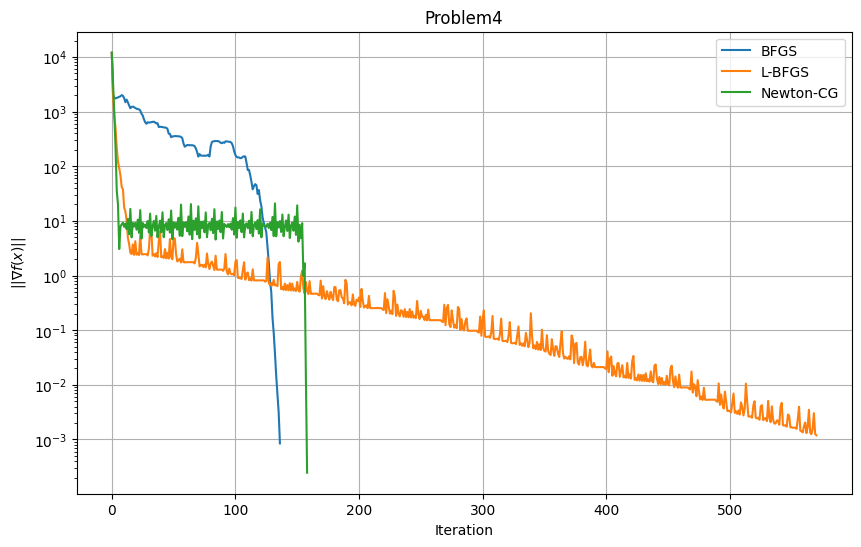

In [11]:
# Problem4: Extended Rosenbrock function with n = 100, x0 = (-1, ..., -1)
Problem= 'Problem4'
n = 100
x0 = -1 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     3283.7475099368 1887.5370064632                0.0019531250   
1     2808.8440122196 1755.2090645891                0.0019531250   
2     2764.8608428129 1761.0347737083                0.0009765625   
3     2739.5101039343 1746.7414700946                0.0078125000   
4     2677.0626580572 1742.2103889858                0.0039062500   
5     2624.9623998568 1739.0304655717                0.0039062500   
6     2484.7420365303 1769.1147386681                0.0156250000   
7     1577.5260447041 1797.4573078964                0.0156250000   
8     612.1276232764  796.9344639690                 0.0039062500   
9     438.7776260346  541.6961486468                 0.0019531250   
10    406.2040207648  359.3872080012                 0.0039062500   
11    382.1141194018  286.4104024767                 0.0039062500   
12    372.5296343228  258.7782461008                 0.0078125000   
13    369.4083034722  246.26189139

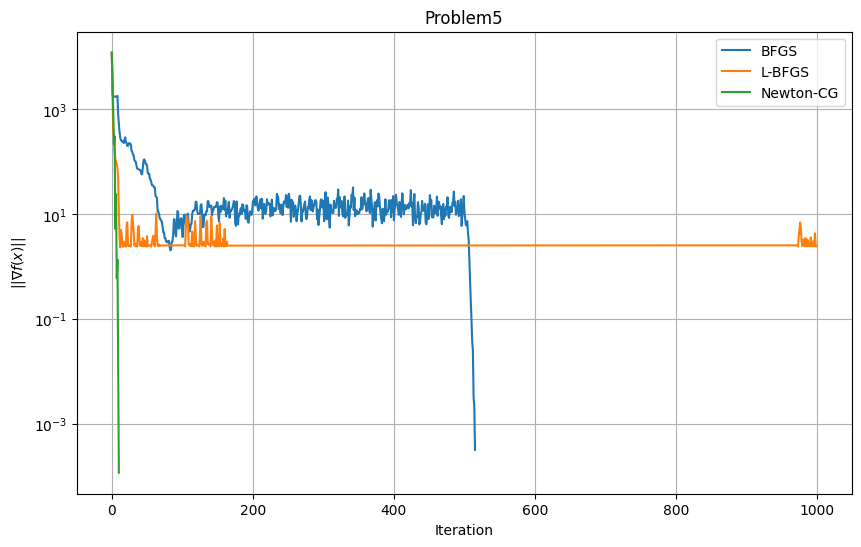

In [12]:
# Problem5: Extended Rosenbrock function with n = 100, x0 = (2, ..., 2)
Problem= 'Problem5'
n = 100
x0 = 2 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     24674.3905761978 5201.1829883244                0.0019531250   
1     24119.0100427428 5141.6404292489                0.0019531250   
2     24025.2894358826 5137.5239935001                0.0009765625   
3     23317.3686158420 5055.2311669309                0.0156250000   
4     22449.3294517965 4954.9303566623                0.0019531250   
5     21259.3304302478 6197.8765746187                0.0078125000   
6     7644.4128890604 6189.8041514074                0.0156250000   
7     3094.3124458128 2805.7749710854                0.0009765625   
8     2817.9816496710 3305.1185763125                0.0019531250   
9     2703.6189210680 2694.9829168869                0.0078125000   
10    2702.8617639119 2694.2385599450                0.0039062500   
11    2323.7427701366 1785.6152148829                0.0156250000   
12    1844.2616151633 971.8672068714                 0.0039062500   
13    1546.3217365515 530.88

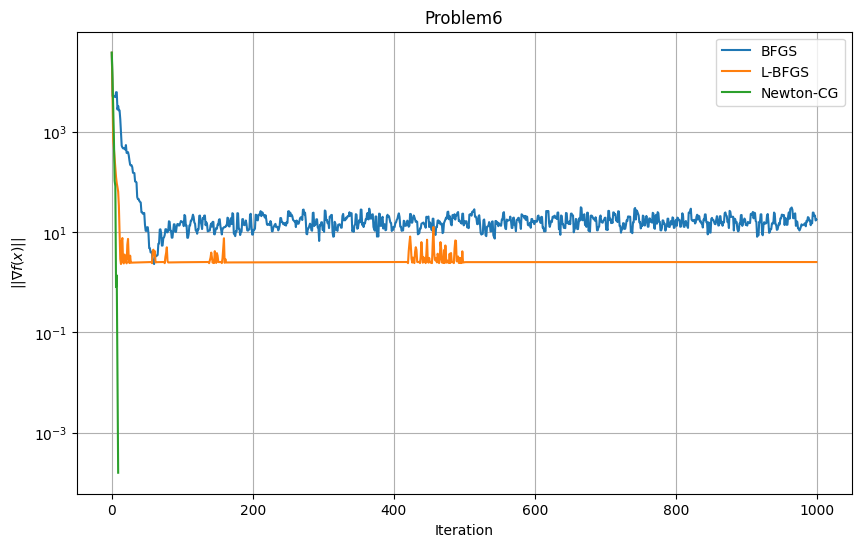

In [13]:
# Problem6: Extended Rosenbrock function with n = 1000, x0 = (2, ..., 2)
Problem= 'Problem6'
n = 1000
x0 = 2 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     238580.8212388074 16184.7888386195               0.0019531250   
1     237412.2305976338 16244.3910285503               0.0039062500   
2     236305.5048777731 16250.8601512267               0.0019531250   
3     233121.9237252771 16307.6891753357               0.0019531250   
4     228714.0105503454 16590.4290957925               0.0009765625   
5     218069.8111281506 20777.3104483089               0.0039062500   
6     139552.4344349393 27557.5120966781               0.0019531250   
7     61811.6160610593 38440.1901637344               0.0004882812   
8     24662.0163522704 12689.4088436181               0.0002441406   
9     24242.9391025251 12775.9180040864               0.0004882812   
10    24141.1410442578 12497.2596081882               0.0039062500   
11    23988.1407869764 12405.8549606762               0.0019531250   
12    23541.2645720079 11913.8679938913               0.0019531250   
13    23433.82

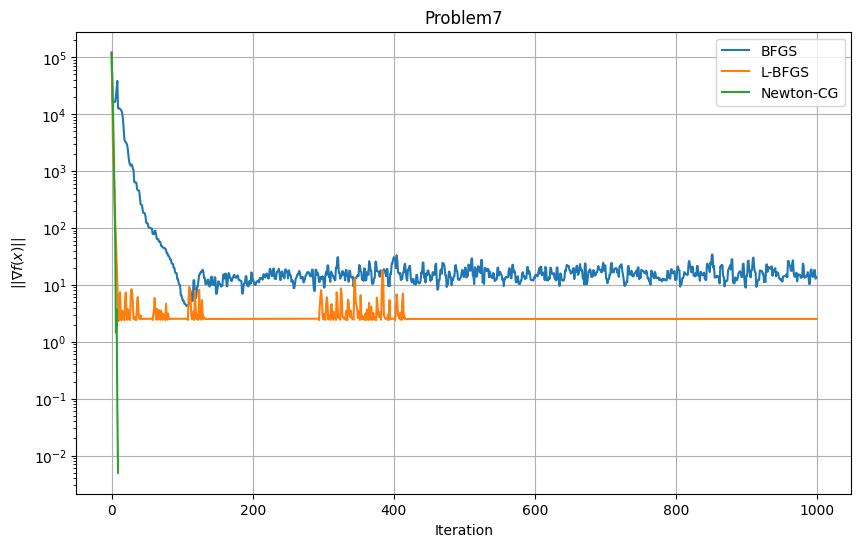

In [14]:
# Problem7: Extended Rosenbrock function with n = 10000, x0 = (2, ..., 2)
Problem= 'Problem7'
n = 10000
x0 = 2 * np.ones(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

In [15]:
# Beale function
def f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    return (y[0] - x[0] + x[0] * x[1])**2 + (y[1] - x[0] + x[0] * x[1]**2)**2 + (y[2] - x[0] + x[0] * x[1]**3)**2

# Gradient of the Beale function
def grad_f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    df_dx = (2 * (y[0] - x[0] + x[0] * x[1]) * (-1 + x[1]) + 
             2 * (y[1] - x[0] + x[0] * x[1]**2) * (-1 + x[1]**2) + 
             2 * (y[2] - x[0] + x[0] * x[1]**3) * (-1 + x[1]**3))

    df_dy = (2 * (y[0] - x[0] + x[0] * x[1]) * x[0] + 
             2 * (y[1] - x[0] + x[0] * x[1]**2) * (2 * x[0] * x[1]) + 
             2 * (y[2] - x[0] + x[0] * x[1]**3) * (3 * x[0] * x[1]**2))

    return np.array([df_dx, df_dy])

# Hessian of the Beale function
def hess_f_beale(x, y=np.array([1.5, 2.25, 2.625])):
    x1, x2 = x

    H11 = 2 * x2**6 + 2 * x2**4 - 4 * x2**3 - 2 * x2**2 - 4 * x2 + 6
    H12 = 12 * x1 * x2**5 + 8 * x1 * x2**3 - 12 * x1 * x2**2 - 4 * x1 * x2 - 4 * x1 + 15.75 * x2**2 + 9 * x2 + 3
    H21 = H12 
    H22 = 30 * x1**2 * x2**4 + 12 * x1**2 * x2**2 - 12 * x1**2 * x2 - 2 * x1**2 + 31.5 * x1 * x2 + 9 * x1

    H = np.array([[H11, H12],
                  [H21, H22]])

    return H


Converged. Gradient norm is less than tolerance.
gradient norm: 0.0
Converged. Gradient norm is less than tolerance.
gradient norm: 0.0
Converged. Gradient norm is less than tolerance.
gradient norm: 0.0


/tmp/ipykernel_2915020/1994240328.py:26: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


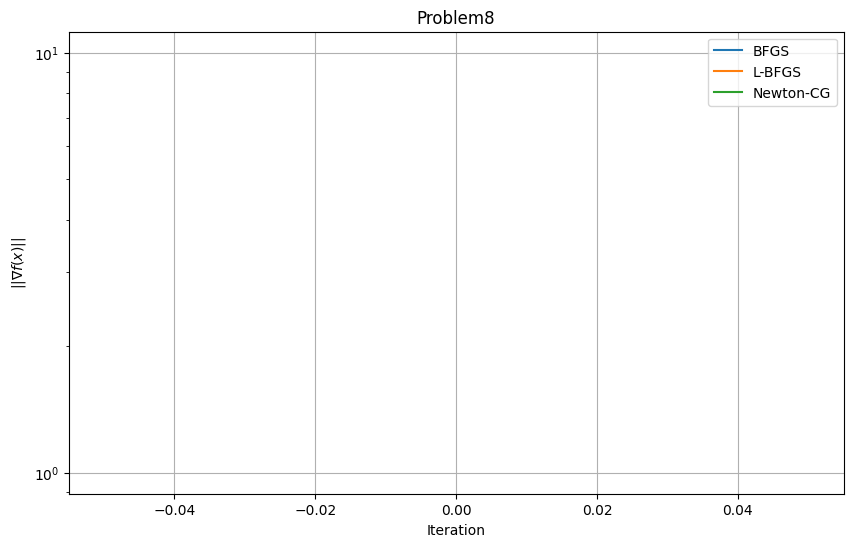

In [16]:
# Problem8: Beale function with x0 = (1, 1)
Problem= 'Problem8'

n = 2
x0 = 1 * np.ones(n)
y = [1.5, 2.25, 2.625]

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

iter  f(x)            ||grad_f(x)||                  alpha          
0     0.0000000000    0.0000000000                   0.5000000000   
Converged. Gradient norm is less than tolerance.
gradient norm: 0.0
iter  f(x)            ||grad_f(x)||                  alpha          
0     0.0000000000    0.0000000000                   0.5000000000   
Converged. Gradient norm is less than tolerance.
gradient norm: 0.0
iter  f(x)            ||grad_f(x)||                  alpha          
0     1.9178527228    14.7061988071                  0.2500000000   
1     1.2129411235    2.1706972935                   1.0000000000   
2     0.9743176533    15.9162687783                  0.2500000000   
3     0.4280541159    1.8300340351                   1.0000000000   
4     0.2192690001    9.7459961236                   0.5000000000   
5     0.0482533110    2.0316941086                   1.0000000000   
6     0.0057751127    2.8965625415                   1.0000000000   
7     0.0000483607    0.0360823126  

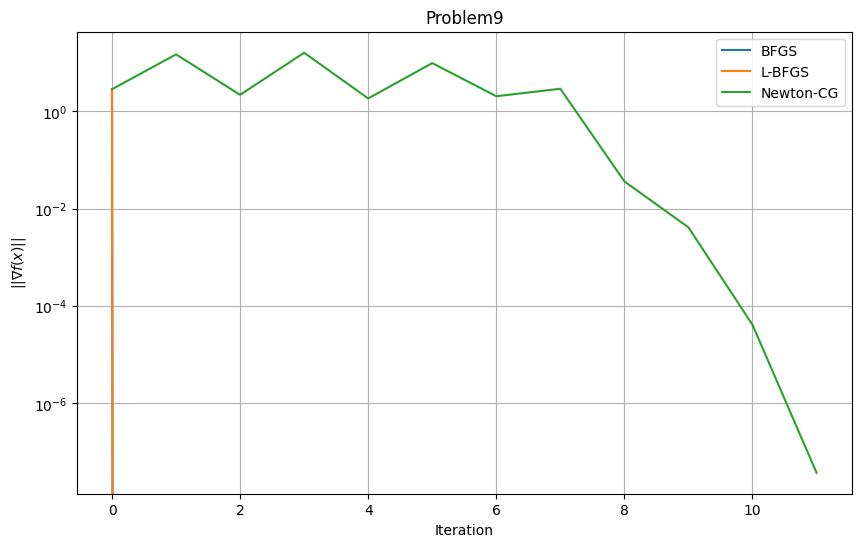

In [17]:
# Problem9: Beale function with x0 = (0, 0)
Problem= 'Problem9'
n = 2
x0 = np.zeros(n)

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

In [18]:
def function_f(x):
    n = len(x)
    f = x[0]**2 + sum((x[i] - x[i+1])**(2*(i+1)) for i in range(n-1)) +0.0
    return f


def function_f(x):
    """Computes the function value f(x)."""
    n = len(x)
    return x[0]**2 + sum((x[i] - x[i+1])**(2*(i+1)) for i in range(n-1))

def gradient_f(x):
    grad = np.array([
        4*x[0] - 2*x[1],
        -2*x[0] + 2*x[1] + 4*(x[1] - x[2])**3,
        -4*(x[1] - x[2])**3 + 6*(x[2] - x[3])**5,
        -6*(x[2] - x[3])**5 + 8*(x[3] - x[4])**7,
        -8*(x[3] - x[4])**7 + 10*(x[4] - x[5])**9,
        -10*(x[4] - x[5])**9 + 12*(x[5] - x[6])**11,
        -12*(x[5] - x[6])**11 + 14*(x[6] - x[7])**13,
        -14*(x[6] - x[7])**13 + 16*(x[7] - x[8])**15,
        -16*(x[7] - x[8])**15 + 18*(-x[9] + x[8])**17,
        -18*(-x[9] + x[8])**17
    ], dtype=float)
    return grad

def hessian_f(x):
    hess = np.array([
        [4, -2, 0, 0, 0, 0, 0, 0, 0, 0],
        [-2, 12*(x[1] - x[2])**2 + 2, -12*(x[1] - x[2])**2, 0, 0, 0, 0, 0, 0, 0],
        [0, -12*(x[1] - x[2])**2, 12*(x[1] - x[2])**2 + 30*(x[2] - x[3])**4, -30*(x[2] - x[3])**4, 0, 0, 0, 0, 0, 0],
        [0, 0, -30*(x[2] - x[3])**4, 30*(x[2] - x[3])**4 + 56*(x[3] - x[4])**6, -56*(x[3] - x[4])**6, 0, 0, 0, 0, 0],
        [0, 0, 0, -56*(x[3] - x[4])**6, 56*(x[3] - x[4])**6 + 90*(x[4] - x[5])**8, -90*(x[4] - x[5])**8, 0, 0, 0, 0],
        [0, 0, 0, 0, -90*(x[4] - x[5])**8, 90*(x[4] - x[5])**8 + 132*(x[5] - x[6])**10, -132*(x[5] - x[6])**10, 0, 0, 0],
        [0, 0, 0, 0, 0, -132*(x[5] - x[6])**10, 132*(x[5] - x[6])**10 + 182*(x[6] - x[7])**12, -182*(x[6] - x[7])**12, 0, 0],
        [0, 0, 0, 0, 0, 0, -182*(x[6] - x[7])**12, 182*(x[6] - x[7])**12 + 240*(x[7] - x[8])**14, -240*(x[7] - x[8])**14, 0],
        [0, 0, 0, 0, 0, 0, 0, -240*(x[7] - x[8])**14, 306*(-x[9] + x[8])**16 + 240*(x[7] - x[8])**14, -306*(-x[9] + x[8])**16],
        [0, 0, 0, 0, 0, 0, 0, 0, -306*(-x[9] + x[8])**16, 306*(-x[9] + x[8])**16]
    ], dtype=float)
    return hess

iter  f(x)            ||grad_f(x)||                  alpha          
0     52773.6688538146 29938.3251922378               0.0000305176   
1     4147.8322706259 5196.0841052030                0.0002441406   
2     415.4337940118  873.1302225939                 0.0004882812   
3     221.6057961165  548.7678258713                 0.0009765625   
4     200.3067126729  512.4740093305                 0.0009765625   
5     191.0172981247  380.1442071106                 0.0039062500   
6     169.8643177937  417.7954747877                 0.0156250000   
7     159.8361388436  403.9585303180                 0.0004882812   
8     154.9362249835  398.0390736322                 0.0039062500   
9     152.7633345935  403.5877649087                 0.0312500000   
10    106.9172960132  354.4934508500                 0.2500000000   
11    92.1506123133   304.2598940985                 1.0000000000   
12    69.2199429565   260.1591774757                 1.0000000000   
13    51.4040685716   226.7722036

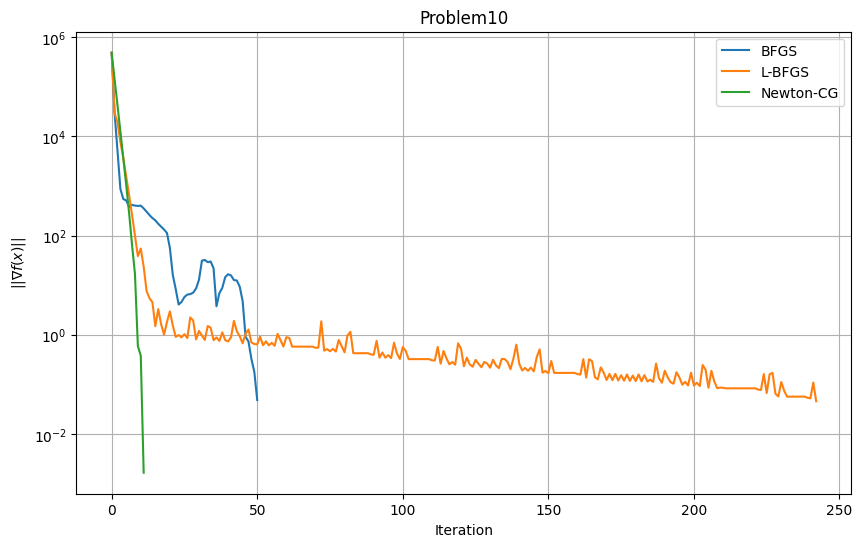

In [19]:
# Problem10: f(x) = x_1^2 + \sum_{i=1}^{n-1} (x_{i} - x_{i+1})^{2i}
Problem= 'Problem10'
n = 10
x0 = np.arange(1, n+1) + 0.0

# BFGS Method with Wolfe Line Search
H0 = np.eye(n)
f_bfgs, iter_bfgs, time_bfgs, term_bfgs, grad_norm_hist_bfgs = bfgs(f_rosenbrock, grad_f_rosenbrock, H0, x0, params)

# L-BFGS Method with Wolfe Line Search
f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs, grad_norm_hist_lbfgs = lbfgs(f_rosenbrock, grad_f_rosenbrock, x0, params)

# Newton-CG Method with Wolfe Line Search
f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg, grad_norm_hist_newton_cg = newton_cg(f_rosenbrock, grad_f_rosenbrock, hessian_f_rosenbrock, x0, params)

df.loc[len(df)] = [f'{Problem}', 'BFGS', f_bfgs, iter_bfgs, time_bfgs, term_bfgs]
df.loc[len(df)] = [f'{Problem}', 'L-BFGS', f_lbfgs, iter_lbfgs, time_lbfgs, term_lbfgs]
df.loc[len(df)] = [f'{Problem}', 'Newton-CG', f_newton_cg, iter_newton_cg, time_newton_cg, term_newton_cg]

plt.figure(figsize=(10, 6))
plt.plot(grad_norm_hist_bfgs, label='BFGS')
plt.plot(grad_norm_hist_lbfgs, label='L-BFGS')
plt.plot(grad_norm_hist_newton_cg, label='Newton-CG')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.title(f'{Problem}')
plt.legend()
plt.grid()

plt.savefig(f'hw3_{Problem}.png')

plt.show()

In [20]:
# turn dataframe into table
df.style

,Problem,Method,f(x),Iterations,Time,Termination
0,Problem1,BFGS,0.000000,29,0.010429,Converged. Gradient norm is less than tolerance.
1,Problem1,L-BFGS,0.000000,67,0.022760,Converged. Gradient norm is less than tolerance.
2,Problem1,Newton-CG,0.000000,2,0.000458,Converged. Gradient norm is less than tolerance.
3,Problem2,BFGS,0.000000,35,0.014987,Converged. Gradient norm is less than tolerance.
4,Problem2,L-BFGS,0.000000,579,0.158072,Converged. Gradient norm is less than tolerance.
5,Problem2,Newton-CG,0.000000,28,0.008818,Converged. Gradient norm is less than tolerance.
6,Problem3,BFGS,3.986613,79,0.024918,Converged. Gradient norm is less than tolerance.
7,Problem3,L-BFGS,0.000000,894,0.241545,Converged. Gradient norm is less than tolerance.
8,Problem3,Newton-CG,0.000000,11,0.003528,Converged. Gradient norm is less than tolerance.
9,Problem4,BFGS,0.000000,137,0.279634,Converged. Gradient norm is less than tolerance.


In [21]:
# save dataframe to csv
df.to_csv('results.csv', index=False)

# save dataframe to latex
df.to_latex('results.tex', index=False)
